In [316]:
############
###IMPORTS##
############

import gdxcc
import sys

sys.path.append('/Library/Frameworks/GAMS.framework/Versions/34/Resources/apifiles/Python/api_39')
sys.path.append('/Library/Frameworks/GAMS.framework/Versions/34/Resources/apifiles/Python/gams')

import gams
import gdxpds
import pandas as pd
import numpy as np
import matplotlib as plt

In [317]:
############
###INPUTS###
############

##Change scenarios here for fault time and microgrid size##

#Save fault time to csv
#fault_end = 193 #no fault
#fault_end = 200 #2-hour fault
#fault_end = 216 #24-hour fault
fault_end = 576 #96-hour fault

fault_time = pd.DataFrame()
for i in range(192,fault_end):
    value = 't'+str(i)
    n = pd.DataFrame([value])
    fault_time = pd.concat([fault_time,n])
fault_time.to_csv("data/fault_time.csv", index=False, header=False)

# Save generator data to csv

# with microturbine
# gen = {'hr_marg':[11.2, 7.8, 0, 7.8],
#     'hr_base':[150, 300, 0, 300],
#     'max_gen':[900, 600, 200, 80],
#     'min_gen':[100, 100, 0, 10],
#     'ramp':[900, 600, 200, 80],
#     'vom':[4.54, 15.7, 2, 15.7],
#     'start_cost':[48000, 1000, 0, 200],
#     'fuel':[2.21, 3.26, 0.13, 3.26],
#     'min_downtime':[32, 4, 0, 4]} 
# generator_data = pd.DataFrame(data=gen, index=['g1','g2','g3','g4'])

# without microturbine
gen = {'hr_marg':[11.2, 7.8, 0],
    'hr_base':[150, 300, 0],
    'max_gen':[900, 600, 750],
    'min_gen':[100, 100, 0],
    'ramp':[900, 600, 750],
    'vom':[4.54, 15.7, 0],
    'start_cost':[48000, 1000, 0],
    'fuel':[2.21, 3.26, 0],
    'min_downtime':[32, 4, 0]} 
generator_data = pd.DataFrame(data=gen, index=['g1','g2','g3'])

generator_data.to_csv("data/generator_data.csv")


##These parameters are constant##

# Save gen_nodes csv
# with microturbine
# gen_nodes = pd.DataFrame([['n1', 'g1'],['n2', 'g2'], ['n3', 'g3'],['n3', 'g4']])

# without microturbine
gen_nodes = pd.DataFrame([['n1', 'g1'],['n2', 'g2'], ['n3', 'g3']])

gen_nodes.to_csv("data/gen_nodes.csv", index=False, header=False)

# Save line data to csv
line = {'n':['n1','n2','n3','n4','n4','n5','n6','n7','n8'],
    'nn':['n4','n7','n9','n5','n6','n7','n9','n8','n9'],
    'x':[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],
    'lim':[2000,2000,2000,2000,2000,2000,2000,2000,2000]}
line_data = pd.DataFrame(data=line)
line_data.to_csv("data/line_data.csv", index=False)

# Save node load factor data to csv
nlf = {'load':[0,0,0.15,0,0.15,0.15,0,0.15,0],
    'crit_load':[0,0,0.15,0,0.12,0.08,0,0.05,0]}
generator_data = pd.DataFrame(data=nlf, index=['n1','n2','n3','n4','n5','n6','n7','n8','n9'])
generator_data.to_csv("data/nodeloadfactors.csv")

In [318]:
############
##RUN GAMS##
############

import os
os.system('gams main.gms')

0

In [319]:
#####################
#IMPORT GAMS OUTPUTS#
#####################

#read in GDX file
gdx_file = '/Users/megatronics/Desktop/CU_Boulder/Classes/Spring_2021/PSPO/Project_2/Code/microgridgams/outputs/MGResults/dispatch_results.gdx'
dataframes = gdxpds.to_dataframes(gdx_file)

In [320]:
###########
##OUTPUTS##
###########

##DATAFRAMES##

generation = dataframes['generation']
lineflow = dataframes['lineflow']
LMP = dataframes['LMP']
load = dataframes['load']
crit_load = dataframes['crit_load']
lostload = dataframes['lostload']
lostcrit = dataframes['lostcrit']
dumped = dataframes['dumped']
costs = dataframes['costs']
penalties = dataframes['penalties']
commit = dataframes['commit']
curtailment = dataframes['curtailment']
storage_gen = dataframes['storage_gen']
storage_charge = dataframes['storage_charge']
storage_soc = dataframes['storage_soc']

In [321]:
##LOST LOAD, DUMPED ENERGY, AND ASSOCIATED PENALTIES##

if lostload['Value'].sum(axis=0) == 0:
    print("No lost regular load")
else:
    print(f"Lost regular load is {lostload['Value'].sum(axis=0).round(decimals=0):,} MWh")

if lostcrit['Value'].sum(axis=0) == 0:
    print("No lost critical load")
else:
    print(f"Lost critical load is {lostcrit['Value'].sum(axis=0).round(decimals=0):,}, MWh")

if dumped['Value'].sum(axis=0) == 0:
    print("No dumped energy")  
else:
    print(f"Dumped energy is {dumped['Value'].sum(axis=0).round(decimals=0)}, MWh")

if penalties['Value'].sum(axis=0) == 0:
    total_penalties = 0
    print("No penalty")  
else:
    total_penalties = penalties['Value'].sum(axis=0).round(decimals=0)
    print(f"Total penalty is $ {total_penalties:,}")

penalties.round(0)

Lost regular load is 19,307.0 MWh
No lost critical load
No dumped energy
Total penalty is $ 193,065,900.0


,n,t,penalty_cat,Value
0,n1,t462,load,58250.0
1,n2,t463,load,42500.0
2,n2,t464,load,19750.0
3,n3,t203,load,88500.0
4,n3,t204,load,654750.0
...,...,...,...,...
269,n3,t573,load,789000.0
270,n3,t574,load,776250.0
271,n3,t575,load,762000.0
272,n6,t433,load,11000.0


Text(0.5, 1.0, 'G4 GENERATION')

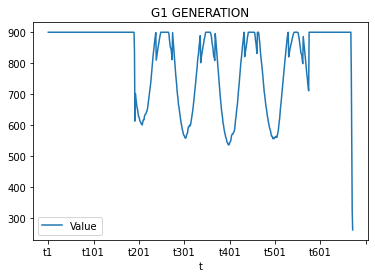

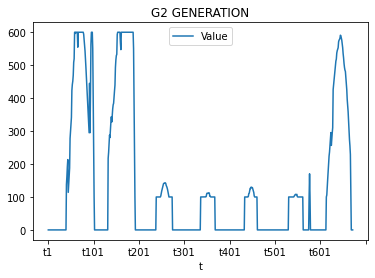

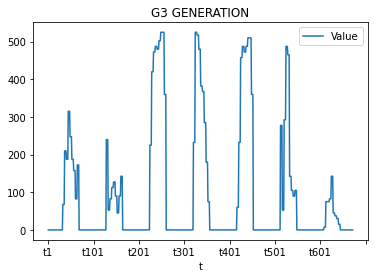

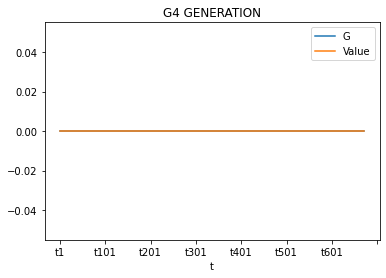

In [322]:
##GENERATOR PLOTS##

new_index = [f't{i}' for i in range(1,673)]

#Generation data for g1 - Coal plant
g1 = generation[generation['G']=='g1'].set_index('t').reindex(index=new_index,fill_value=0)
g1.plot().set_title("G1 GENERATION")

#Generation data for g2 - Slack (NG)
g2 = generation[generation['G']=='g2'].set_index('t').reindex(index=new_index,fill_value=0)
g2.plot().set_title("G2 GENERATION")

#Generation data for g3 - Solar
g3 = generation[generation['G']=='g3'].set_index('t').reindex(index=new_index,fill_value=0)
g3.plot().set_title("G3 GENERATION")

#Generation data for g4 - Microturbine
g4 = generation[generation['G']=='g4'].set_index('t').reindex(index=new_index,fill_value=0)
g4.plot().set_title("G4 GENERATION")

Total MWh generated is 704,035 MWh


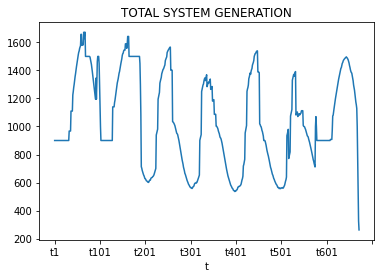

In [323]:
total_system_gen = g1['Value']+g2['Value']+g3['Value']+g4['Value']
total_system_gen.plot().set_title("TOTAL SYSTEM GENERATION")
print(f"Total MWh generated is {total_system_gen.sum():,.0f} MWh")

Total G1 cost is $ 16,234,323.0
Total G2 cost is $ 4,191,147.0
Total G3 cost is $ 0.0
Total G4 cost is $ 0.0
Total generation cost is $ 20,425,470.0
Total operational cost is $ 213,491,370.0
% Penalty is 90%


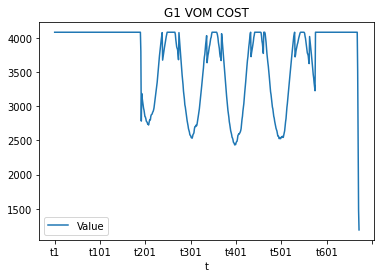

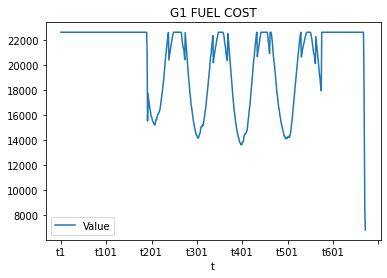

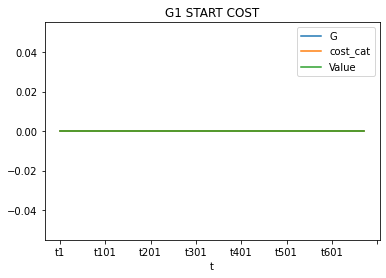

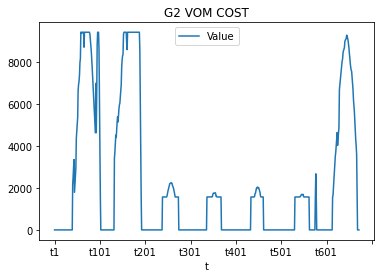

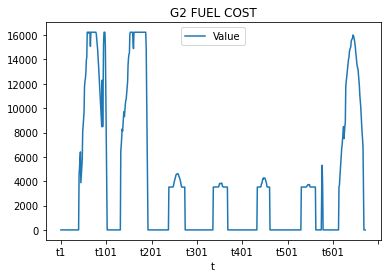

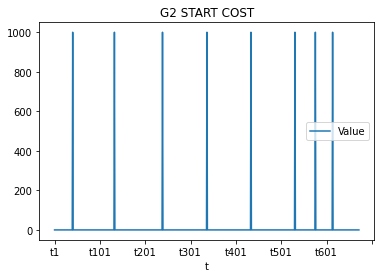

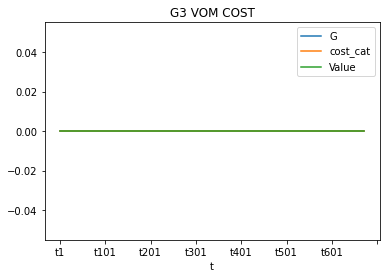

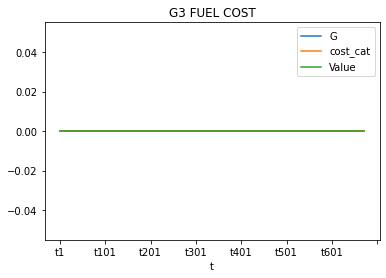

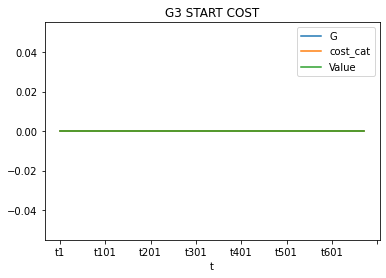

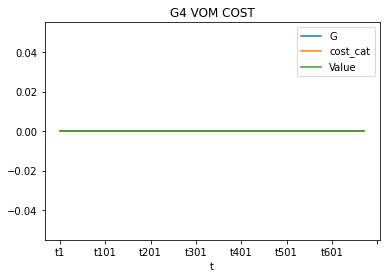

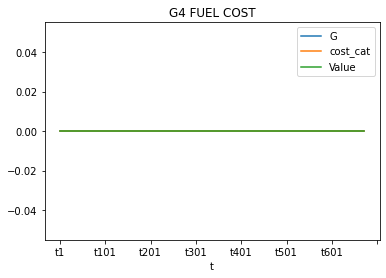

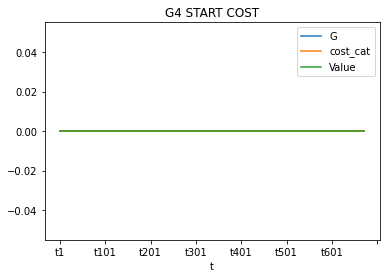

In [324]:
##GENERATION COSTS##

vom = costs[costs['cost_cat']=='vom']
fuel = costs[costs['cost_cat']=='fuel']
start = costs[costs['cost_cat']=='start']

new_index = [f't{i}' for i in range(1,673)]

#Generation cost for g1 - Coal plant
g1_vom = vom[vom['G']=='g1'].set_index('t').reindex(index=new_index,fill_value=0)
g1_vom.plot().set_title("G1 VOM COST")

g1_fuel = fuel[fuel['G']=='g1'].set_index('t').reindex(index=new_index,fill_value=0)
g1_fuel.plot().set_title("G1 FUEL COST")

g1_start = start[start['G']=='g1'].set_index('t').reindex(index=new_index,fill_value=0)
g1_start.plot().set_title("G1 START COST")

g1_total_costs = g1_vom['Value'].sum(axis=0).round(decimals=0)+g1_fuel['Value'].sum(axis=0).round(decimals=0)+g1_start['Value'].sum(axis=0).round(decimals=0)
print(f"Total G1 cost is $ {g1_total_costs:,}")

#Generation cost for g2 - Slack (NG)
g2_vom = vom[vom['G']=='g2'].set_index('t').reindex(index=new_index,fill_value=0)
g2_vom.plot().set_title("G2 VOM COST")

g2_fuel = fuel[fuel['G']=='g2'].set_index('t').reindex(index=new_index,fill_value=0)
g2_fuel.plot().set_title("G2 FUEL COST")

g2_start = start[start['G']=='g2'].set_index('t').reindex(index=new_index,fill_value=0)
g2_start.plot().set_title("G2 START COST")

g2_total_costs = g2_vom['Value'].sum(axis=0).round(decimals=0)+g2_fuel['Value'].sum(axis=0).round(decimals=0)+g2_start['Value'].sum(axis=0).round(decimals=0)
print(f"Total G2 cost is $ {g2_total_costs:,}")

#Generation cost for g3 - Solar
g3_vom = vom[vom['G']=='g3'].set_index('t').reindex(index=new_index,fill_value=0)
g3_vom.plot().set_title("G3 VOM COST")

g3_fuel = fuel[fuel['G']=='g3'].set_index('t').reindex(index=new_index,fill_value=0)
g3_fuel.plot().set_title("G3 FUEL COST")

g3_start = start[start['G']=='g3'].set_index('t').reindex(index=new_index,fill_value=0)
g3_start.plot().set_title("G3 START COST")

g3_total_costs = g3_vom['Value'].sum(axis=0).round(decimals=0)+g3_fuel['Value'].sum(axis=0).round(decimals=0)+g3_start['Value'].sum(axis=0).round(decimals=0)
print(f"Total G3 cost is $ {g3_total_costs:,}")

#Generation cost for g4 - Microturbine
g4_vom = vom[vom['G']=='g4'].set_index('t').reindex(index=new_index,fill_value=0)
g4_vom.plot().set_title("G4 VOM COST")

g4_fuel = fuel[fuel['G']=='g4'].set_index('t').reindex(index=new_index,fill_value=0)
g4_fuel.plot().set_title("G4 FUEL COST")

g4_start = start[start['G']=='g4'].set_index('t').reindex(index=new_index,fill_value=0)
g4_start.plot().set_title("G4 START COST")

g4_total_costs = g4_vom['Value'].sum(axis=0).round(decimals=0)+g4_fuel['Value'].sum(axis=0).round(decimals=0)+g4_start['Value'].sum(axis=0).round(decimals=0)
print(f"Total G4 cost is $ {g4_total_costs:,}")

total_gen_cost = g1_total_costs + g2_total_costs+g3_total_costs+g4_total_costs
print(f"Total generation cost is $ {(total_gen_cost):,}")
print(f"Total operational cost is $ {total_gen_cost+total_penalties:,}")
print(f"% Penalty is {total_penalties/(total_gen_cost+total_penalties):,.0%}")

Text(0.5, 1.0, 'SOC')

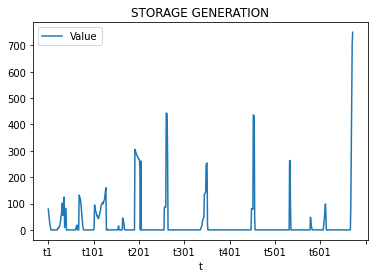

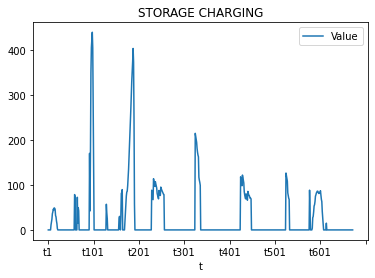

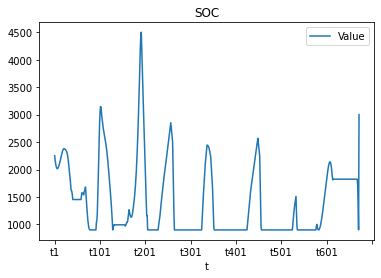

In [325]:
##STORAGE##

# Plot storage generation
storage_gen = storage_gen.set_index('t')
new_index = [f't{i}' for i in range(1,673)]
storage_gen = storage_gen.reindex(index=new_index,fill_value=0)
storage_gen['s'] = 's1'
storage_gen.plot().set_title("STORAGE GENERATION")

# Plot storage charge
storage_charge = storage_charge.set_index('t')
new_index = [f't{i}' for i in range(1,673)]
storage_charge = storage_charge.reindex(index=new_index,fill_value=0)
storage_charge['s'] = 's1'
storage_charge.plot().set_title("STORAGE CHARGING")

# Plot storage state of charge
storage_soc = storage_soc.set_index('t')
storage_soc.plot().set_title("SOC")

Total MWh used is 780,627 MWh


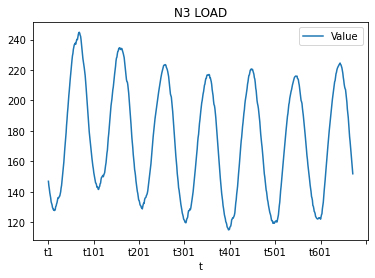

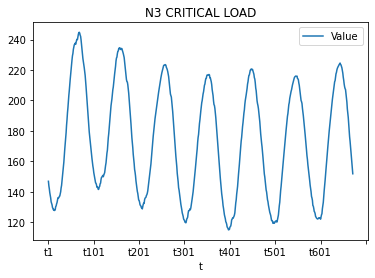

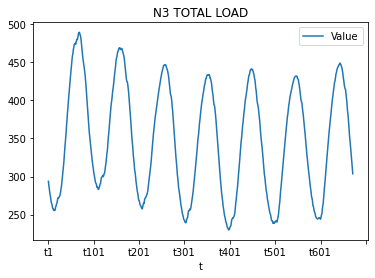

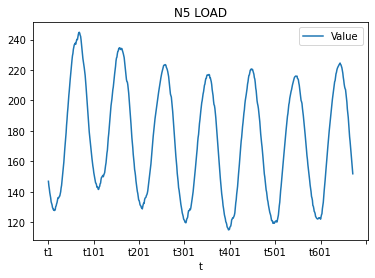

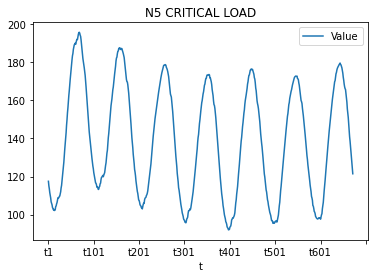

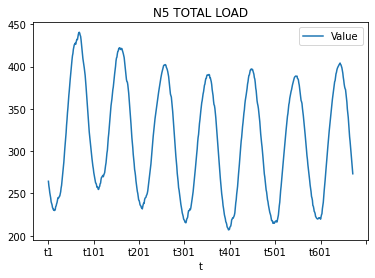

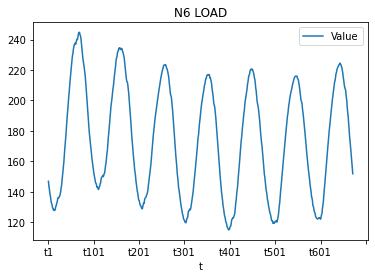

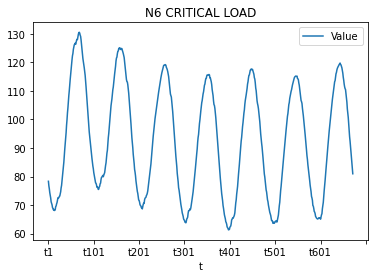

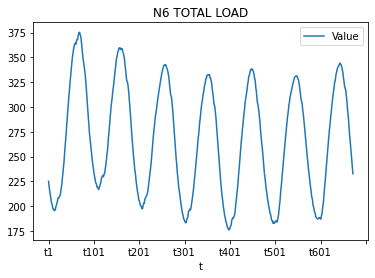

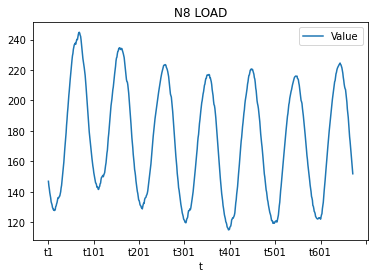

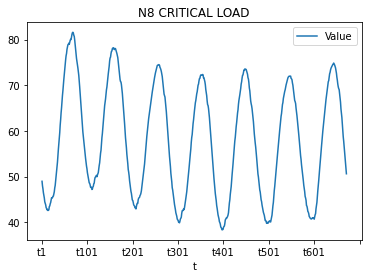

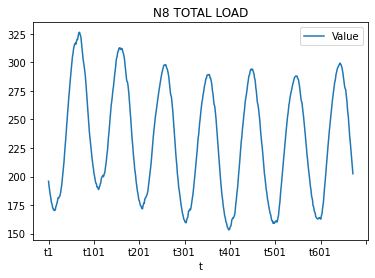

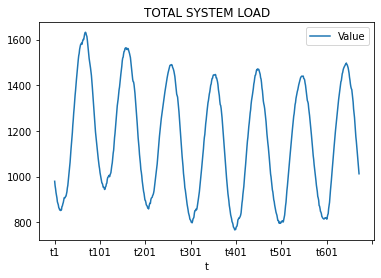

In [326]:
##LOAD AND CRITICAL LOAD##

# N3 load plots
load_3 = load[load['n']=='n3'].set_index('t')
load_3.plot().set_title("N3 LOAD")

crit_load_3 = crit_load[crit_load['n']=='n3'].set_index('t')
crit_load_3.plot().set_title("N3 CRITICAL LOAD")

total_load_3 = load_3 + crit_load_3
total_load_3.plot().set_title("N3 TOTAL LOAD")

# N5 load plots
load_5 = load[load['n']=='n5'].set_index('t')
load_5.plot().set_title("N5 LOAD")

crit_load_5 = crit_load[crit_load['n']=='n5'].set_index('t')
crit_load_5.plot().set_title("N5 CRITICAL LOAD")

total_load_5 = load_5 + crit_load_5
total_load_5.plot().set_title("N5 TOTAL LOAD")

# N6 load plots
load_6 = load[load['n']=='n6'].set_index('t')
load_6.plot().set_title("N6 LOAD")

crit_load_6 = crit_load[crit_load['n']=='n6'].set_index('t')
crit_load_6.plot().set_title("N6 CRITICAL LOAD")

total_load_6 = load_6 + crit_load_6
total_load_6.plot().set_title("N6 TOTAL LOAD")

# N8 load plots
load_8 = load[load['n']=='n8'].set_index('t')
load_8.plot().set_title("N8 LOAD")

crit_load_8 = crit_load[crit_load['n']=='n8'].set_index('t')
crit_load_8.plot().set_title("N8 CRITICAL LOAD")

total_load_8 = load_8 + crit_load_8
total_load_8.plot().set_title("N8 TOTAL LOAD")

total_system_load = total_load_3 + total_load_5 + total_load_6 + total_load_8
total_system_load.plot().set_title("TOTAL SYSTEM LOAD")

print(f"Total MWh used is {total_system_load['Value'].sum():,.0f} MWh")

Text(0.5, 1.0, 'LMP')

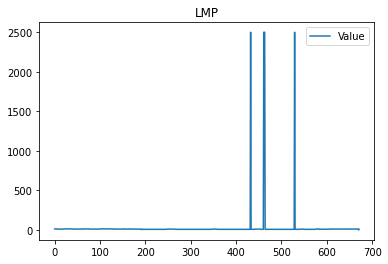

In [327]:
##LOCATIONAL MARGINAL PRICE##

#LMP Node 1
LMP1 = LMP[LMP['n']=='n1']
LMP1.plot().set_title("LMP")

#Might graph other nodes, but should be the same on all nodes due to high line limits

Text(0.5, 1.0, 'G4 ON')

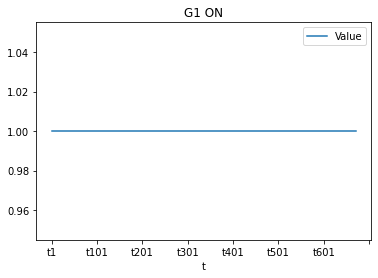

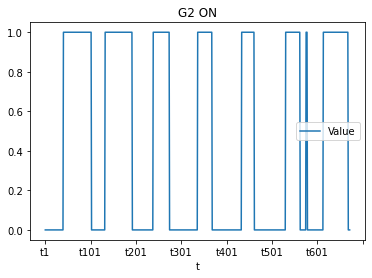

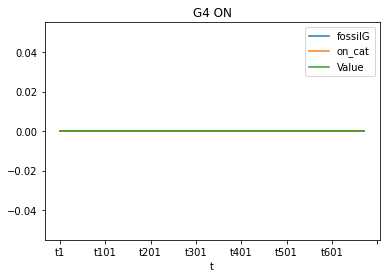

In [328]:
##COMMIT PLOTS##
on = commit[commit['on_cat']=='commit']
start = commit[commit['on_cat']=='start']
stop = commit[commit['on_cat']=='stop']

new_index = [f't{i}' for i in range(1,673)]

#Commit data for g1 - Coal plant
g1_on = on[on['fossilG']=='g1'].set_index('t').reindex(index=new_index,fill_value=0)
g1_on.plot().set_title("G1 ON")

#Commit data for g2 - Slack (NG)
g2_on = on[on['fossilG']=='g2'].set_index('t').reindex(index=new_index,fill_value=0)
g2_on.plot().set_title("G2 ON")

#Commit data for g4 - Microturbine
g4_on = on[on['fossilG']=='g4'].set_index('t').reindex(index=new_index,fill_value=0)
g4_on.plot().set_title("G4 ON")

In [329]:
## LINEFLOW PLOTS##

#Line from bus 1 to bus 4
L14 = lineflow[(lineflow['n']=='n1')&(lineflow['nn']=='n4')].set_index('t').reindex(index=new_index,fill_value=0)
F14 = fault[(fault['n']=='n1')&(fault['nn']=='n4')].set_index('t')
L14 = pd.concat([L14, F14['Value']], axis=1)
L14.plot().set_title("L14")

#Line from bus 2 to bus 7
L27 = lineflow[(lineflow['n']=='n2')&(lineflow['nn']=='n7')].set_index('t').reindex(index=new_index,fill_value=0)
F27 = fault[(fault['n']=='n2')&(fault['nn']=='n7')].set_index('t')
L27 = pd.concat([L27, F27['Value']], axis=1)
L27.plot().set_title("L27")

#Line from bus 3 to bus 9
L39 = lineflow[(lineflow['n']=='n3')&(lineflow['nn']=='n9')].set_index('t').reindex(index=new_index,fill_value=0)
F39 = fault[(fault['n']=='n3')&(fault['nn']=='n9')].set_index('t')
L39 = pd.concat([L39, F39['Value']], axis=1)
L39.plot().set_title("L39")

#Line from bus 4 to bus 5
L45 = lineflow[(lineflow['n']=='n4')&(lineflow['nn']=='n5')].set_index('t').reindex(index=new_index,fill_value=0)
F45 = fault[(fault['n']=='n4')&(fault['nn']=='n5')].set_index('t')
L45 = pd.concat([L45, F45['Value']], axis=1)
L45.plot().set_title("L45")

#Line from bus 4 to bus 6
L46 = lineflow[(lineflow['n']=='n4')&(lineflow['nn']=='n6')].set_index('t').reindex(index=new_index,fill_value=0)
F46 = fault[(fault['n']=='n4')&(fault['nn']=='n6')].set_index('t')
L46 = pd.concat([L46, F46['Value']], axis=1)
L46.plot().set_title("L46")

#Line from bus 5 to bus 7
L57 = lineflow[(lineflow['n']=='n5')&(lineflow['nn']=='n7')].set_index('t').reindex(index=new_index,fill_value=0)
F57 = fault[(fault['n']=='n5')&(fault['nn']=='n7')].set_index('t')
L57 = pd.concat([L57, F57['Value']], axis=1)
L57.plot().set_title("L57")

#Line from bus 6 to bus 9
L69 = lineflow[(lineflow['n']=='n6')&(lineflow['nn']=='n9')].set_index('t').reindex(index=new_index,fill_value=0)
F69 = fault[(fault['n']=='n6')&(fault['nn']=='n9')].set_index('t')
L69 = pd.concat([L69, F69['Value']], axis=1)
L69.plot().set_title("L69")

#Line from bus 7 to bus 8
L78 = lineflow[(lineflow['n']=='n7')&(lineflow['nn']=='n8')].set_index('t').reindex(index=new_index,fill_value=0)
F78 = fault[(fault['n']=='n7')&(fault['nn']=='n8')].set_index('t')
L78 = pd.concat([L78, F78['Value']], axis=1)
L78.plot().set_title("L78")

#Line from bus 8 to bus 9
L89 = lineflow[(lineflow['n']=='n8')&(lineflow['nn']=='n9')].set_index('t').reindex(index=new_index,fill_value=0)
F89 = fault[(fault['n']=='n8')&(fault['nn']=='n9')].set_index('t')
L89 = pd.concat([L89, F89['Value']], axis=1)
L89.plot().set_title("L89")

NameError: name 'fault' is not defined

In [ ]:
##CURTAILMENT##
curtailment